#Downloading and Preparing Anime Faces Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Colab_Notebooks/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d soumikrakshit/anime-faces

In [ ]:
!unzip /content/anime-faces.zip

#Importing the Necessaries Libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, LeakyReLU
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, AvgPool2D, UpSampling2D
from keras.layers import Activation, BatchNormalization, Add, Multiply
from keras.losses import mse, binary_crossentropy
from tensorflow.keras import backend as K
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

#Loading and Preprocessing Anime Face Dataset

In [ ]:
data_path = '/content/data'
image_size = (64, 64)
batch_size = 32

latent_dim = 1024
num_epochs = 50

In [ ]:
def load_and_preprocess_data(data_path, image_size):
    datagen = ImageDataGenerator(rescale=1./255)
    data_generator = datagen.flow_from_directory(
        data_path,
        target_size=image_size,
        class_mode='input',
        shuffle=True
    )

    images, _ = next(data_generator)
    return images


images = load_and_preprocess_data(data_path, image_size)

#Displaying Anime Face Images

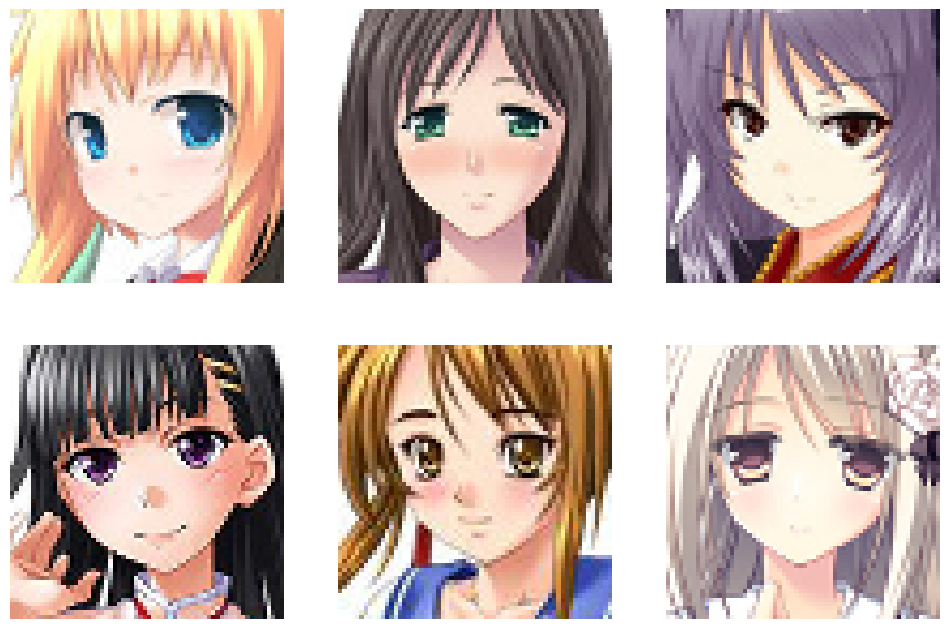

In [ ]:
def display_images(images):
    num_images = len(images)
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    for i in range(2):
        for j in range(3):
            if i*3 + j < num_images:
                axes[i, j].imshow(images[i*3 + j])
                axes[i, j].axis('off')

    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()

display_images(images[:6])

#Variational Autoencoders (VAE)

##Building the Encoder

In [ ]:
def build_encoder(input_shape, latent_dim):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (1, 1), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (4, 4), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, (4, 4), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dense(2 * latent_dim)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling)([z_mean, z_log_var])

    encoder_model = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder_model

encoder = build_encoder((64, 64, 3), latent_dim)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           256       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)           0         ['batch_normalization[0]

##Building the Decoder

In [ ]:
def build_decoder(latent_dim):
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(4 * 4 * 512)(decoder_input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Reshape((4, 4, 512))(x)

    x = Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    outputs = Conv2DTranspose(3, (5, 5), padding='same', activation='sigmoid')(x)

    decoder_model = Model(decoder_input, outputs, name='decoder')
    return decoder_model

decoder = build_decoder(latent_dim)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_3 (Dense)             (None, 8192)              8396800   
                                                                 
 batch_normalization_5 (Bat  (None, 8192)              32768     
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 256)         3277056   
 anspose)                                                  

##Building the Variational Autoencoder (VAE)

In [ ]:
vae_input = Input(shape=(64, 64, 3))
vae_output = decoder(encoder(vae_input)[2])
vae = Model(vae_input, vae_output, name='vae')

vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 encoder (Functional)        [(None, 1024),            23741312  
                              (None, 1024),                      
                              (None, 1024)]                      
                                                                 
 decoder (Functional)        (None, 64, 64, 3)         12840131  
                                                                 
Total params: 36581443 (139.55 MB)
Trainable params: 36558019 (139.46 MB)
Non-trainable params: 23424 (91.50 KB)
_________________________________________________________________


##Training the Variational Autoencoder (VAE)

In [ ]:
def vae_loss(inputs, outputs):
    reconstruction_loss = tf.reduce_mean(tf.square(inputs - outputs))
    return reconstruction_loss

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        n = 10
        random_images = images[np.random.choice(images.shape[0], n, replace=False)]
        reconstructed_images = vae.predict(random_images)

        plt.figure(figsize=(20, 4))
        for i in range(n):
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(random_images[i])
            plt.axis('off')

            ax = plt.subplot(2, n, i + n + 1)
            plt.imshow(reconstructed_images[i])
            plt.axis('off')

        plt.show()

In [ ]:
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

vae.compile(optimizer=optimizer, loss=vae_loss, metrics=[ssim_metric, psnr_metric])

vae.fit(images, images, epochs=50, batch_size=batch_size, callbacks=[CustomCallback()])

##Generating Anime Faces using the Variational Autoencoder (VAE)

In [ ]:
def generate_anime_faces(num_faces=10):
    random_latent_vectors = np.random.normal(size=(num_faces, latent_dim))
    generated_images = decoder.predict(random_latent_vectors)

    plt.figure(figsize=(15, 6))
    for i in range(num_faces):
        ax = plt.subplot(2, num_faces // 2, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

generate_anime_faces()

##Saving the Variational Autoencoder (VAE)

In [ ]:
vae.save('/content/vae_model.h5')
encoder.save('/content/encoder_model.h5')
decoder.save('/content/decoder_model.h5')